In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Randomizing Users: Two Methods Compared
=======================================

Tommy Guy

Last Edited: November 17, 2016

At KDD 2016, Netflix published a paper called [Improving the Sensitivity of Online Controlled Studies](http://www.kdd.org/kdd2016/subtopic/view/improving-the-sensitivity-of-online-controlled-experiments-case-studies-at-) that among other things explains how Netflix randomizes users for controlled experiments.

The thing is, I've never heard of anyone using their method! Most systems including the platform on [my team](http://www.exp-platform.com) use a stateless approach based on hashing that optimizes for efficient, repeatable assignment. Netflix uses a queue-based system that emphasizes balanced assignments but at the expense of storage and complexity.

In this post, I'll make a psuedo-implementation of each approach and discuss the tradeoffs inherent in each. I'm pretty convinced I don't want to take Netflix's approach, but you can be your own judge.

First, Let's Design Some Experiments
---------------------------

To set the stage, let's create some dummy experiments. (You can probably skip this section if you really want.)
Each experiment has two or more buckets that light up to two different code paths. Typically, one of these buckets is the "control" or existing experience. An experiment is really a set of buckets of a fractional size of the total population. The variable `experiments` below is a very basic schematic of a set of experiments.

We assume that the system will handle potentially hundreds of experiments and tens of millions of users, though not every experiment will be applicable to every user at any given time. A few reasons why an experiment wouldn't apply to a particular user include the experiment uses a filtered subset of traffic (say, en-gb only) or the experiment is set up to be mutually exclusive of another experiment. The latter case happens when we want to test two potentially interacting ideas and ensure that a user isn't exposed to the cross product of possible outcomes simultaneously. 

In [1]:
num_total_buckets = 100
        
experiments = {
    'ChangeButton': {
        'buckets': [  # describe the set of available buckets.
            {'name': 'blue', 'allocation': .25},  # note that only half of users are in buckets.
            {'name': 'red', 'allocation': .25}
        ],
        'filters': {  # describe any filters that apply to the experiment. These must be knowable at assignment time.
            'locale': 'en-us'
        },
        'id': 'ChangeButton'
    },
    'ChangeLogo': {
        'buckets': [  # describe the set of available buckets.
            {'name': 'stickfigure', 'size': .10},
            {'name': 'professional', 'size': .10}
        ],
        'filters': {  # describe any filters that apply to the experiment. These must be knowable at assignment time.
            'locale': 'en-us'
        },
        'id': 'ChangeLogo'
    }
}

#
# Set up a very basic base randomizer. Subclasses will override _randomize_user.
#
class BaseExperimentRandomizer(object):

    def filters_apply(self, user, experiment):
        filters = experiment['filters']
        return all([user.get(k) == v for k, v in filters.items()])
    
    def assign_user(self, user, experiment_id):
        experiment = experiments[experiment_id]
        if not self.filters_apply(user, experiment):
            return 'noop'
        return self._randomize_user(user['id'], experiment)
    
    def _randomize_user(self, user_id, experiment):
        # Dumb case simply returns the first bucket. 
        # http://xkcd.com/221/
        return experiment[0]['name']

The gist is that experiments define a set of filters and a set of buckets. Each bucket has a name and a size. To tell if a user is exposed to an experiment, we check whether the filters apply then use a randomizing function. Our initial randomization is [pretty dumb](http://xkcd.com/221/) and we'll improve it below.

How to Judge a Randomization System
-----------------------------------

Here are the criteria I will use to judge the two approaches.

**Must haves**
* Repeatability: A user will be in the same experiment for a given experiment provided the experiment's allocation is stable.
* Ramp Up and Ramp Down: We need to be able to quickly change allocations including killing experiments that show problems.
* Experiment Exclusion: We can configure two experiments to not overlap if we want. A user in treatment or control for experiment 1 will not be in treatment or control for experiment 2. (Aside: I know you could share controls. Let's keep it simple.)

**Statistical Efficiency**
* Statistical Dependability: Does the system reliably produce unbiased, balanced allocations of users?
* Stratification: Is stratified sampling possible? (The original topic of Netflix's paper).

The first three requirements are considered table stakes: we have to be able to keep a consistent experience. What I'm calling statistical efficiency is really judging whether the system can avoid accidentally biasing the random split. We can usually detect when that bias occurs (which I'll discuss below) but such failure require an experiment rerun which reduces our efficiency. Therefore a system where more random allocations are usable in production would be better.


Given our criteria, let's introduce the two systems!

Hash and Bucket Randomization
-----------------------------

The standard algorithm for randomizing users was introduced in several papers including papers from [Google](http://research.google.com/pubs/pub36500.html) and [Microsoft](http://www.exp-platform.com/Documents/GuideControlledExperiments.pdf). Assume every user has a unique, persistent identifier that is known at assignment time. Use a series of salted hashes and identifier to determine a user's assignment. The first example below doesn't handle exclusion but introduces the hashing system. The second example is a full implementation.

In [2]:
from itertools import accumulate

class SimpleHashAndBucketRandomizer(BaseExperimentRandomizer):
    # Does not do experiment exclusion.
    
    def _randomize_user(self, user_id, experiment):
        salted_user = str(user_id) + experiment['id']
        hash_value = hash(salted_user) % num_total_buckets
        
        buckets = experiment['buckets']
        cumulative_buckets = list(accumulate([bucket['allocation'] * num_total_buckets for bucket in buckets]))
        bucket_index = sum([bb < hash_value for bb in cumulative_buckets])
        if bucket_index == len(buckets):
            return 'noop'  # User isn't in experiment
        return buckets[bucket_index]['name']
        

*One word of caution* I'm using python's built-in hash function here because hash functions aren't my focus. Don't do that in production. We've [got a paper](http://www.exp-platform.com/Documents/controlledExperimentDMKD.pdf) (page 26) arguing that in more complicated setups involving multiple overlapping experiments, MD5 is a good option though Spooky hash will also probably work.

**Repeatability**
HashAndBucket randomization is a *stateless* randomizer: we store state about which experiments are active but we can recompute a user's information on the fly from the stable user id.

**Rampup and Shutdown**
Since the system doesn't persist user assignments, one can change allocation and it will be immediately reflected. If a user is in treatment "ChangeButton" and we decide to shut off that experiment, the very next call for that user will automatically move them into "noop".

**Experiment Exclusion**
If we want to run two experiments such that a user can't be in both, we use the same hash salt on both experiments, but we assign the experiments to non-overlapping buckets. If we have an experiment with 25% of users in each bucket and another with 10% in each bucket, we use a single salt and assign 50 buckets to one experiment and 20 to the other. In the implementation below, we also introduce a per-experiment salt, which I'll come back to later.

In [3]:
# Put our two experiments on a single salt.
hashes = {
    'UISalt1': {
        'salt': 'abracadabra',
        'current_buckets': [
            {'name': 'ChangeButton', 'allocation': .50},
            {'name': 'ChangeLogo', 'allocation': .20},
        ]
    }
}

# Add salt to every experiment.
for key in experiments.keys():
    experiments[key]["salt"] = "UISalt1"

# Define a within-experiment allocation (essentially, make experiment use the whole hash.)
experiments_sans_noop = {
    'ChangeButton': {
        'buckets': [
            {'name': 'blue', 'allocation': .50},
            {'name': 'red', 'allocation': .50}
        ],
        'id': 'ChangeButton'
    },
    'ChangeLogo': {
        'buckets': [
            {'name': 'stickfigure', 'allocation': .50},
            {'name': 'professional', 'allocation': .50}
        ],
        'id': 'ChangeLogo'
    }
}

In [4]:
class HashAndBucketRandomizer(BaseExperimentRandomizer):
    # Does not do experiment exclusion.
    
    def _do_randomization(self, user_id, salt, allocation):
        # Helper function that basically does the work in SimpleHashAndBucketRandomizer.
        # We need it twice in this system: once to pick an experiment and once to pick a bucket in 
        # The experiment.
        salted_user = str(user_id) + salt
        hash_value = hash(salted_user) % num_total_buckets
        cumulative_buckets = list(accumulate([bucket['allocation'] * num_total_buckets for bucket in allocation]))
        bucket_index = sum([bb <= hash_value for bb in cumulative_buckets])
        if bucket_index == len(allocation):
            return 'noop2'  # User isn't in experiment. Should never show up.
        return allocation[bucket_index]['name']
    
    def _randomize_user(self, user_id, experiment):
        # Get the hashset, which records a salt and the allocations.
        experiment_hashset = hashes[experiment['salt']]
        experiment_salt = experiment_hashset['salt']
        experiment_allocation = experiment_hashset['current_buckets']
        experiment_name = self._do_randomization(user_id, experiment_salt, experiment_allocation)
        
        if experiment_name != experiment['id']:
            return 'noop'
        
        return self._do_randomization(user_id, experiment_name, experiments_sans_noop[experiment_name]['buckets'])


*Aside why do we have two hashes?* Sometimes, it's advantageous to reuse salts for multiple experiments. Having a double hash lets us ensure that even if we use the same part of a mod space for two experiments in two different time periods, the experiments remain randomized with respect to each other.

Netflix Case
------------

Netflix takes a queue-based approach as described in their paper. Each experiment has a queue of assignments that has been randomly sorted. In their paper, they say that each queue is of length 100, which means one can specify experiment allocations to nearest 1% (as opposed to the nearest 0.1% in the hashing system above). Allocating a flight for a user pops the latest assignment off the queue, assigns the user, and puts the assignment back at the end of the queue. Presumably popping and re-pushing is an atomic operation.

Their system requires a bit of extra setup to maintain the queues, which we do below in `assignment_queues`.

In [5]:
import random
queue_depth = 100
assignment_queues = {
    'ChangeButton': {'q': ['blue'] * 25 + ['red'] * 25 + ['noop'] * 50, 'i': 0},
    'ChangeLogo': {'q': ['stickfigure'] * 10 + ['professional'] * 10 + ['noop'] * 80, 'i': 0}
}
# randomize
for k, v in assignment_queues.items():
    random.shuffle(v['q'])

In [6]:
class QueueRandomizer(BaseExperimentRandomizer):
    
    def _randomize_user(self, user_id, experiment):
        queue = assignment_queues[experiment['id']]
        current_value = queue['q'][queue['i']]
        queue['i'] = (queue['i'] + 1) % queue_depth
        
        return current_value
        

A similar check as above confirms that we're getting appropriately sized allocations. 

**Repeatability**

Netflix's queues cycle, making them stateful. To remember which assignment was given to a user, one must store that information somewhere. Given the pervasive use of experiment allocations in the code base, this lookup needs to be fast and very high availability. This could be expensive in a system with potentially tens of millions of users in each of a hundred experiments.

**Rampup and Shutdown**
Experiment rampup (expanding exposure) and shutoff is also complicated because the user state needs to kept up to date (necessitating at least a call to see if the experiment is still live). 

**Exclusion**
Exclusion is easy enough: simply stack two experiments in the same queue. Only one bucket from the combined experiment set will ever be assigned to a particular user. 

*Aside: exclusive experiments with dedicated controls* In my examples, I'm assuming two experiments that are set to be mutually exclusive have their own controls. This is wasteful: we would be assigning 35% of traffic in our toy example to control rather than the minimal requirement of 25%. There are optimizations that are possible, but one caveat is that it's easier to treat deal with separate controls in production when experiments rarely start and end at the same time. 

So far, it's unclear why to use a queue-based system since it requires adding a state storage problem to our workload.
What about our statistical requirements? Does the queue-based system improve on hash-and-bucket?

Does a Hash-Based System Produce Reliable Randomization?
--------------------------------------------------------

Two requirements for statistical reliability are a balanced sample ratio and a correct distribution of statistics under the null hypothesis. 

The queue-based system obviously produces a balanced sample ratio: the maximum difference in user counts is 50 which occurs in an unrandomized queue that is halfway through the cycle. What about the hash and bucket system?

**How to think about a balanced sample ratio**

A/B testing creates a situation where the exposure of a user to a change is independent of any property of the user: selection bias is eliminated because ''selection" of the treatment is a random effect. If our hash and bucket system is working correctly, we will get an even distribution of users into treatment and control, which we confirm with Pearson's Chi-Square Test.

In the next code section, we produce 10000 random splits of 10000 users, and we show that in fact the splits are balanced.

In [7]:
from collections import Counter

def compute_histogram(assignments):
    final_dict = Counter()
    for a in assignments:
        final_dict[a] += 1
    return final_dict

import numpy as np
from scipy.stats import chisquare
from uuid import uuid4
num_users = 10000
num_trials = 10000
assumed_values = np.array([.25, .5, .25]) * num_users

p_values = []
all_values = []

for i in range(num_trials):
    users  = ({'locale': 'en-us', 'id': uuid4()} for u in range(num_users))
    randomizer = HashAndBucketRandomizer()
    assignment = [randomizer.assign_user(u, 'ChangeButton') for u in users]
    assignment_hist = compute_histogram(assignment)
    values = np.array([assignment_hist[k] for k in sorted(assignment_hist.keys())])  # blue, noop, red
    all_values.append(values)
    p_values.append(chisquare(values, assumed_values).pvalue)
    

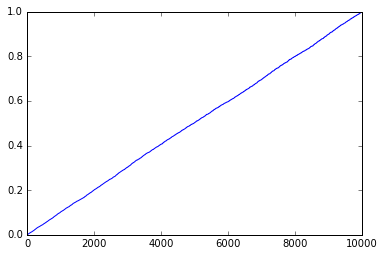

In [11]:
plot(sorted(p_values))

In [14]:
print(min(p_values))

8.83768942277e-05


In [21]:
all_values[np.argmin(p_values)]

array([2419, 5213, 2368])

The distribution of treatments to controls follows a chi-square distribution, which implies that there is no *structural* imbalance between the count of treatments and the count of controls in my implementation. However, there is still *random* fluctuation: our worst imbalance in 10000 tries was 2419 treatments, 2368 controls, and 5213 not-assigned with a p-value of 8.83e-5. I argue that this doesn't matter. The important property of a randomization engine is that it produce two samples such that the probability of assignment is independent of any user property that could correlate with the outcome of interest. Consider the extreme case: let's say we use a biased coin to assign groups that turns up heads 55% of the time. Can we use that coin in an A/B test? Yes iff the coin bias not be correlated with anything else in the world.

Since our randomizer isn't inherently biased, one of the most important checks one can run at analysis time is a Sample Ratio Mismatch (SRM) check: always verify that the randomization engine is producing the expected sample ratio of treatments and controls by using a chi-squared test to check the null hypothesis that your sample ratio is correct. We've seen many cases of this failing due to misconfiguration, logging or cooking problems, or poorly designed experiment trigger conditions. Since we use a chi-squared test to check for SRMs, we run a slight risk of rejecting valid experimental results due to the natural false positive rate.

This is a slight advantage to Netflix's queue system: there is no chance of an unnecessary rejection due to false positive rate in the sample ratio check. Since their distributions have a near absolute balance, one can easily verify that observed sample ratios meet the designation (though they still need to check since usually SRMs are traced to something other than the randomizer.)

There are three reasons why I don't think this is a big deal. 

1) True positives tend to be extreme. When we have identified true positive SRMs in the past, the p-value tended to be below a reasonable false positive rate (say, below 1e-5). This is due to the high statistical power associated with a chi-square test in an experiment with hundreds of thousands to millions of users.

2) If a significant percentage of the user base is not new during experiment time, one can try multiple experiment-specific salts in the event of an SRM in pre-experiment data. In other words, I can efficiently reject salts that cause randomly low p-values in my SRM test prior to committing traffic to my experiment. (Caveat: make sure to verify post-hoc that your initial salt choices are maintaining a Chi-square distribution!) 

3) As Netflix describes, introducing stratification or a distributed queue tends to lead to a more "spread" in treatment/control counts since the perfect balance a queue guarantees only exists within a single queue. In reality, Netflix is using a distributed queue. But again, this random fluctuation doesn't matter other than making verification more difficult.

The second choice above doesn't help for experiments with new users, which is an important moment where Netflix and many other companies are particularly interested in experimentation. However, most problems are due to bad logging or trigger conditions, not due to a biased randomizer.